In [1]:
ENG = "English"

data = []
header = None
n_colums = None
cnt_lines = 0
broken_lines_cnt = 0


# https://github.com/droher/etymology-db
for line in open("/home/alexey/Downloads/etymology.csv"):
    cnt_lines += 1
    
    if header is None:
        header = line.split(',')
        n_columns = len(header)
        print("Header:")
        print(line)
        continue

    tokens = line.split(',')
    if len(tokens) < n_columns:
        broken_lines_cnt += 1
        continue

    lang1 = tokens[1]    
    term1 = tokens[2]
    reltype = tokens[3]
    lang2 = tokens[5]
    term2 = tokens[6]
    
    
    if lang1 == '' or term1 == '' or lang2 == '' or reltype == '':
        broken_lines_cnt += 1
        continue
    
    if lang1 != ENG and lang2 != ENG:
        continue

    data.append(((lang1, term1), reltype, (lang2, term2)))

print(cnt_lines, len(data), broken_lines_cnt)

Header:
term_id,lang,term,reltype,related_term_id,related_lang,related_term,position,group_tag,parent_tag,parent_position

3884570 877911 381792


In [2]:
from collections import Counter

all_relations = Counter(i[1] for i in data)
all_relations

Counter({'borrowed_from': 57617,
         'derived_from': 75964,
         'doublet_with': 5737,
         'has_root': 7255,
         'etymologically_related_to': 114952,
         'cognate_of': 48068,
         'inherited_from': 25855,
         'abbreviation_of': 125,
         'clipping_of': 858,
         'has_affix': 43441,
         'is_onomatopoeic': 221,
         'compound_of': 49245,
         'calque_of': 3756,
         'has_prefix_with_root': 203286,
         'has_suffix': 107727,
         'has_confix': 19602,
         'blend_of': 11263,
         'unadapted_borrowing_from': 506,
         'has_prefix': 100272,
         'back-formation_from': 578,
         'learned_borrowing_from': 257,
         'orthographic_borrowing_from': 26,
         'named_after': 646,
         'semantic_loan_of': 154,
         'phono-semantic_matching_of': 364,
         'initialism_of': 52,
         ' do as the Romans do"': 1,
         ' it\'s got bells on"': 1,
         ' no love"': 2,
         ' Brute"': 1,
  

In [3]:
data1 = []
for line in data:
    if all_relations[line[1]] > 1:
        data1.append(line)

print(len(data) - len(data1), "filtered")
data = data1
print(len(data), "left")

34 filtered
877877 left


In [4]:
langs1 = set(i[0][0] for i in data)
langs1

{' English ',
 'Abenaki',
 'Acehnese',
 'Adyghe',
 'Afar',
 'Afrikaans',
 'Ainu',
 'Ajië',
 'Akan',
 'Akkadian',
 'Akolet',
 'Alabama',
 'Albanian',
 'Alemannic German',
 'Alutiiq',
 'American Sign Language',
 'Amharic',
 'Amis',
 'Ancient Greek',
 'Andalusian Arabic',
 'Angloromani',
 'Ankave',
 'Antigua and Barbuda Creole English',
 'Antillean Creole',
 'Arabic',
 'Aragonese',
 'Araki',
 'Aramaic',
 'Armenian',
 'Aromanian',
 'Ashkun',
 'Assamese',
 'Asturian',
 'Atayal',
 'Atong (India)',
 'Aukan',
 'Avestan',
 'Aymara',
 'Azerbaijani',
 'Bakhtiari',
 'Bakung',
 'Balkan Romani',
 'Baltic Romani',
 'Baluchi',
 'Banoni',
 'Bashkir',
 'Basque',
 'Bavarian',
 'Belarusian',
 'Bende',
 'Bengali',
 'Berbice Creole Dutch',
 'Bhojpuri',
 'Biak',
 'Bikol Central',
 'Bislama',
 'Bourguignon',
 'Breton',
 'Broome Pearling Lugger Pidgin',
 'Brunei Malay',
 'Bulgarian',
 'Burmese',
 'Buryat',
 'Bwatoo',
 'Cahuilla',
 'Caló',
 'Cappadocian Greek',
 'Carpathian Romani',
 'Catalan',
 'Cebuano',
 'Ce

In [5]:
approved_relations = set([
    'borrowed_from', # заимствовано -- однозначно подходит
    'derived_from', # норм
#    'doublet_with', # это скорее про "братьев"
#    'has_root', # неинтересно
#    'etymologically_related_to', # тоже "братья", пока забьём
#    'cognate_of', # это про ложные совпадения
    'inherited_from', # подходит
    'abbreviation_of', # etc, etc
    'clipping_of', # скорее всего это будет из английского, но оставим
#    'has_affix', # не подходит
#    'is_onomatopoeic', # это индикатор слова-звукоподражания. тут word1 и word2 совпадают
    'compound_of', # для слов типа watchlist. надо обрабатывать отдельно (+1 уровень вложенности),
    # но иногда сразу на другие языки перескакивает
    'calque_of', # калька -- хорошо
#    'has_prefix_with_root',
#    'has_suffix',
#    'has_confix',
    'blend_of', # как compound но обрезаны конец и начало соединяемых слов
    'unadapted_borrowing_from',
#    'has_prefix',
#    'back-formation_from',
    'learned_borrowing_from',
    'orthographic_borrowing_from',
    'named_after',
    'semantic_loan_of',
    'phono-semantic_matching_of',
    'initialism_of',
])

In [6]:
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# взято из http://agailloty.rbind.io/project/nlp_clean-text/
def clean_text(text):
    """
    This function takes as input a text on which several 
    NLTK algorithms will be applied in order to preprocess it
    """
    if type(text) == str:
        tokens = word_tokenize(text)
    elif type(text) == list:
        tokens = text
    else:
        raise ValueError("Provide string or list of words")
    # Remove the punctuations
    tokens = [word for word in tokens if word.isalpha()]
    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Remove stopword
    tokens = [word for word in tokens if not word in stopwords.words("english")]
    # Lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    return tokens

[nltk_data] Downloading package punkt to /home/alexey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alexey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alexey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alexey/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
clean_text("This function takes as input a text on which several ")

['function', 'take', 'input', 'text', 'several']

In [8]:
all_related = dict()

def append_val(dct, key, val):
    if key in dct:
        dct[key].append(val)
    else:
        dct[key] = [val]


for (lang1, word1), rel, (lang2, word2) in data:
    if lang1 != ENG or (rel not in approved_relations):
        continue
    
    append_val(all_related, word1.lower(), (rel, lang2.lower(), word2))

In [9]:
for word in ['ok', 'sweet', 'nice', 'cool']:
    print(all_related[word])
    print()

[('borrowed_from', 'english', 'OK')]

[('inherited_from', 'middle english', 'sweete'), ('inherited_from', 'old english', 'swēte'), ('inherited_from', 'proto-west germanic', '*swōtī'), ('inherited_from', 'proto-germanic', '*swōtuz'), ('inherited_from', 'proto-indo-european', '*swéh₂dus')]

[('inherited_from', 'middle english', 'nyce'), ('derived_from', 'old french', 'nice'), ('derived_from', 'latin', 'nescius'), ('borrowed_from', 'french', 'Nice'), ('derived_from', 'latin', 'Nīcaea'), ('derived_from', 'ancient greek', 'Νῑ́καια')]

[('inherited_from', 'middle english', 'cool'), ('inherited_from', 'old english', 'cōl'), ('inherited_from', 'proto-west germanic', '*kōl(ī)'), ('inherited_from', 'proto-germanic', '*kōlaz'), ('derived_from', 'proto-indo-european', '*gel-'), ('inherited_from', 'middle english', 'colen'), ('inherited_from', 'old english', 'cōlian'), ('inherited_from', 'proto-west germanic', '*kōlēn'), ('derived_from', 'proto-indo-european', '*gel-'), ('inherited_from', 'middle e

In [27]:
def calc_latin_german_word(word):
    word = word.lower()
    
    if word not in all_related:
        return 0, 0
    
    cnt_german, cnt_latin = 0, 0
    for rel, lang, word_2 in all_related[word]:
        if 'latin' in lang or 'french' in lang:
            cnt_latin += 1
        if 'german' in lang:
            cnt_german += 1
    
    total = cnt_latin + cnt_german
    if total == 0:
        return 0, 0
    else:
        return cnt_latin / total, cnt_german / total
    

def calc_latin_german(text, normalize = True):
    text = clean_text(text)
    sum_german, sum_latin = 0., 0.
    for word in text:
        upd_latin, upd_german = calc_latin_german_word(word)
        sum_latin += upd_latin
        sum_german += upd_german
    if normalize:
        total = sum_german + sum_latin
        if total < 1e-5:
            raise ValueError("Text is not on English or too small")
        return sum_latin / total, sum_german / total
    else:
        return sum_latin, sum_german

In [11]:
nltk.download('brown')
nltk.download('webtext')
nltk.download('inaugural')

[nltk_data] Downloading package brown to /home/alexey/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package webtext to /home/alexey/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package inaugural to /home/alexey/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [13]:
from nltk.corpus import brown

results = dict()

for category in brown.categories():
    latin, german = calc_latin_german(list(brown.words(categories=category)))
    results["br_" + category] = latin
    
    print(category, 100 * latin, "% latin,", 100 * german, "% german")

adventure 37.45129895044715 % latin, 62.54870104955285 % german
belles_lettres 61.24702211110788 % latin, 38.75297788889212 % german
editorial 61.51165017483148 % latin, 38.48834982516851 % german
fiction 40.72321772321774 % latin, 59.27678227678225 % german
government 75.75616728639417 % latin, 24.24383271360583 % german
hobbies 58.83887812643851 % latin, 41.16112187356149 % german
humor 49.61882371635139 % latin, 50.38117628364861 % german
learned 71.98417782499743 % latin, 28.01582217500257 % german
lore 58.314793003067734 % latin, 41.68520699693227 % german
mystery 40.33840476463422 % latin, 59.66159523536578 % german
news 60.69730389683763 % latin, 39.302696103162376 % german
religion 61.16967611568951 % latin, 38.830323884310495 % german
reviews 58.865909226960945 % latin, 41.13409077303907 % german
romance 38.69577987289229 % latin, 61.30422012710771 % german
science_fiction 49.19467787114851 % latin, 50.80532212885149 % german


In [14]:
from nltk.corpus import webtext

latin, german = calc_latin_german(list(webtext.words()))

In [15]:
latin, german

(0.46448111992149405, 0.535518880078506)

In [16]:
results['webtext'] = latin

In [17]:
from nltk.corpus import inaugural
latin, german = calc_latin_german(inaugural.raw())

In [55]:
results['inagugural']

0.6942610260660633

In [18]:
results['inagugural'] = latin

In [19]:
pairs = sorted([(value, key) for key, value in results.items()])

In [20]:
y = [i[0] for i in pairs]
x = [i[1] for i in pairs]

<BarContainer object of 17 artists>

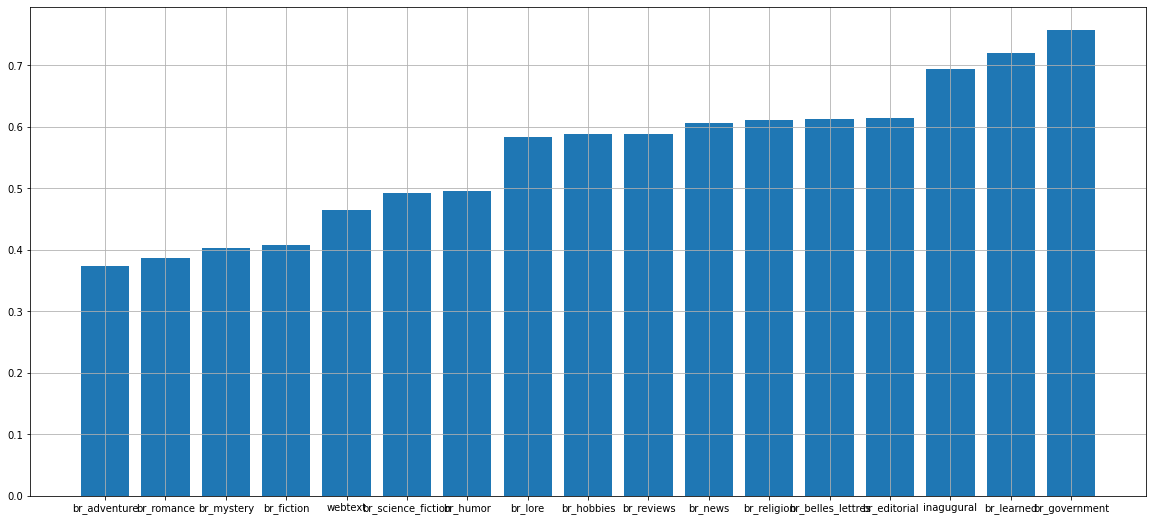

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 9))
plt.grid(True)
plt.bar(x, y)